In [1]:
import pyspark
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import datetime, timedelta
import numpy as np
from scipy.interpolate import interp1d

In [2]:
def set_pyspark():
    myConf = pyspark.SparkConf()
    spark = pyspark.sql.SparkSession.builder\
        .master("local")\
        .appName("myApp")\
        .config(conf = myConf)\
        .getOrCreate()
    return spark

## 데이터 불러오기 & 전처리

In [27]:
def data_load(file_name, date, label, spark):
    data_df = pd.read_excel(os.path.join("data", file_name), names=["data"])
    data_list = list(data_df["data"])
    
    temp = []
    data_temp = []
    for i in range(len(data_list)):
        temp.append(data_list[i])
        if i % 2 != 0:
            data_temp.append(temp)
            temp = []
    
    dataRDD = spark.sparkContext.parallelize(data_temp)
    
    changeData = dataRDD.map(lambda x: (x[0].split(), x[1]))\
                    .map(lambda x: (date + " " + x[0][2], x[1]))\
                    .map(lambda x: (x[0].replace(" ", " 0"), x[1]) if len(x[0]) == 15 else (x[0], x[1]))\
                    .sortByKey(lambda x: x[0])
    
    time_stamp = changeData.map(lambda x: x[0][-5:]).collect()
    data_count = changeData.map(lambda x: x[1]).collect()
    
    return time_stamp, data_count, changeData

## 선형보간전 데이터 전처리

In [28]:
def before_linear(data, date, spark):
    _data = data.collect()
    _f, _e = _data[0][1], _data[-1][1]
    _data = dict(_data)
    
    start_time = date + " 00:00"
    end_time = date + " 23:59"
    
    _data[start_time] = _f
    _data[end_time] = _e

    _data = sorted(_data.items(), key = lambda x: x[0])
    return _data

## 선형 보간 함수

In [11]:
def isitRight(step_data):
    step_data = sorted(step_data)
    for i in range(len(step_data) - 1):
        now = datetime.strptime(step_data[i][0], "%Y-%m-%d %H:%M")
        nxt = datetime.strptime(step_data[i+1][0], "%Y-%m-%d %H:%M")

        now_value = step_data[i][1]
        nxt_value = step_data[i+1][1]

        new_t = (nxt - now) / 2
        # nn분 30초 나오는 애들은 30초를 버리고
        # nn분만 살려서 가는 형태로 갑시다
        if new_t < timedelta(minutes = 1):
            continue
        else:
            if new_t % timedelta(seconds = 60) != timedelta(seconds = 0):
                new_t -= timedelta(seconds = 30)

            new_value = (now_value + nxt_value) / 2
            new_t = now + new_t
            
            new_t.strftime("%Y-%m-%d %H:%M")
            new_t = str(new_t)
            new_t = new_t[:-3]
            step_data.append((new_t, new_value))
            
    return step_data

In [12]:
def yesItIsRight(data):
    while len(data) < 1440:
        data = isitRight(data)
    data = sorted(data, key = lambda x: x[0])
    return data

## 그래프 그리기 함수

In [14]:
def draw_graph(data, label, points):
    _x = spark.sparkContext.parallelize(data).map(lambda x: x[0]).collect()
    _y = spark.sparkContext.parallelize(data).map(lambda x: x[1]).collect()
    
    plt.plot(_x[:], _y[:], label = label)
    plt.rcParams['figure.figsize'] = (20, 4)
    plt.rcParams['font.size'] = 10
    plt.legend()

## 전체 기능 함수

In [21]:
date = "2021-12-06"
h = "hearts"
s = "steps"
file_name = "211206_steps.xlsx"

In [29]:
def load_and_linear(date, file_name, label, spark):
    _t, _d, _a = data_load(file_name, date, label, spark)
    _dlinear = before_linear(_a, date, spark)
    _all = yesItIsRight(_dlinear)
    return _all

In [5]:
spark = set_pyspark()

22/01/19 00:40:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/01/19 00:40:01 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [31]:
all_data = load_and_linear(date, file_name, s, spark)

/usr/local/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/shuffle.py:60: UserWarning: Please install psutil to have better support with spilling


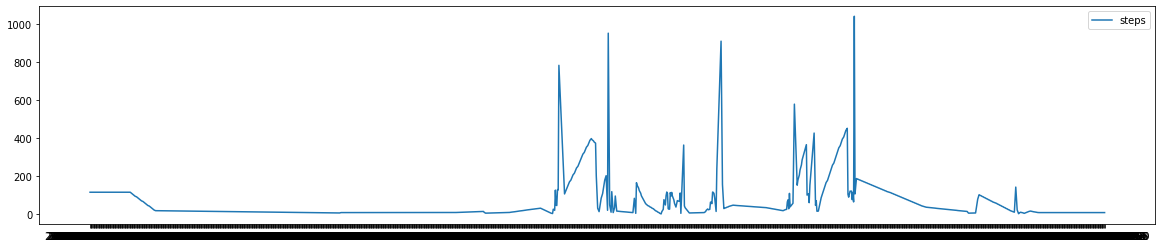

In [32]:
draw_graph(all_data, s, "1")

## 데이터 저장

In [33]:
def save_data(data, file_name):
    all_df = pd.DataFrame(data)
    all_df.to_csv(os.path.join("data", file_name))

In [35]:
save_file_name = "all_day_" + file_name[:-4] + "csv"

In [37]:
save_data(all_data, save_file_name)